# Calulate SEUC transport in INALT20 and observation along 23$^{\circ}$W

For both, model and observations we calculate the central position $ Y_{CM} $ and along-pathway intensity $ INT $ of zonal currents using the algorithm of Hsin (2012). 

\begin{equation}
Y_{CM}(x,t) = \frac{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} y\ u(x,y,z,t)\ dy\ dz}{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} u(x,y,z,t)\ dy\ dz}
\label{equ_Y_CM}
\end{equation}

\begin{equation}
INT(x,t) = \int_{Z_l}^{Z_u} \int_{Y_{CM}-W}^{Y_{CM}+W} u(x,y,z,t)\ dy\ dz 
\label{equ_INT}
\end{equation}


where $y$ is latitude, $x$ is longitude, $u$ is zonal velocity, $z$ is depth, $t$ is time, $Z_u$ ($Z_l$) is upper (lower) boundary of the flow, $Y_N$ ($Y_S$) is northern (southern) limit of the flow, and $W$ is the half mean width of the flow.

![](../figures/INALT20_obs_23w_comparison/1_INALT20_obs_23w_1999_2012.png)

The SEUC total limits are 3$^{\circ}$-7$^{\circ}$S, 30-550m. For transport calculation of the SEUC we use the following boundary conditions:

$Z_u = 25.5\,$kg$\,$m$^{-3}$, $Z_l = 27.0\,$kg$\,$m$^{-3}$, $Y_N = 3^{\circ}$S, $Y_S = 6.5^{\circ}$S

Based on the 23$^{\circ}$W ship section we choose $W = 2^{\circ}$.

The depth of the SEUC core $Z_{CM}$ will be estimated similar to $Y_{CM}$:

\begin{equation}
Z_{CM}(x,t) = \frac{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} z\ u(x,y,z,t)\ dy\ dz}{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} u(x,y,z,t)\ dy\ dz}
\label{equ_Z_CM}
\end{equation}

Huettle-Kabus used: 3$^{\circ}$-6$^{\circ}$S,  $\sigma_{\Theta} = 25.5-26.8\,$kg$\,$m$^{-3}$,

## Tech preample

In [1]:
%matplotlib inline
import os
import dask
import cmocean
import datetime
# import nc_time_axis
import cftime
import gsw
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
# import xorca_box as xbox
from pathlib import Path
from scipy.io import loadmat
# from xorca.lib import load_xorca_dataset
# from xorca_lonlat2ij import get_ij
from datetime import datetime

## Dask jobqueue and client
To controle the resources used for parallel computations on computing nodes.

In [2]:
import dask_jobqueue
cluster = dask_jobqueue.SLURMCluster(
    # Dask worker size
    cores=4, memory='24GB',
    processes=1, # Dask workers per job
    # SLURM job script things
    queue='cluster', walltime='01:00:00',
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',
    log_directory='./slurm_logs'
)

/gxfs_home/geomar/smomw294/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33265 instead
  http_address["port"], self.http_server.port


In [3]:
from dask.distributed import Client

In [4]:
client = Client(cluster)
client

Client Scheduler: tcp://172.18.4.12:41053 Dashboard: http://172.18.4.12:33265/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
cluster.adapt(
    minimum=1, maximum=20,
)

## Output parameters

In [6]:
out_dir_data = Path('../data/INALT20_SEUC_boundaries/')
Path(out_dir_data).mkdir(parents=True, exist_ok=True)
out_data_1 = 'SEUC_boundaries'

out_dir_fig = Path('../figures/INALT20_SEUC_boundaries/')
Path(out_dir_fig).mkdir(parents=True, exist_ok=True)
out_fig_1 = 'INALT_JRA_CORE_SEUC_zonal'
out_fig_2 = 'INALT_JRA_SEUC_zonal'
out_fig_3 = 'INALT_CORE_SEUC_zonal'
out_fig_4 = 'INALT_JRA_CORE_SEUC_merid'
out_fig_5 = 'INALT_JRA_SEUC_merid'
out_fig_6 = 'INALT_CORE_SEUC_merid'
fig_format = '.png'

savefig = 1; #set one if figures should be saved

## Input parameters
For INALT20 

In [7]:
run_calc_1M = 0 #set 1 if annual mean should be recalculated
global_data_path = Path("/sfs/fs1/work-geomar1/smomw044/")
JRA_path = "INALT20.L46-KFS10X"
exp_id = "INALT20.L46-KFS10?"

CORE_path = "shared/INALT20.L46-KFS044-S"
CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

restr_years1 = "20[0-1][0-9]"  # restricts to 2010 and 2011

# chunk sizes
chu_x = 100 # None means take the full dataset
chu_y = 100
chu_z = 9
chu_t = 1

# variables wanted
vars_want = ['vosaline','votemper','vozocrtx']

Calculation of EUC - Boundary conditions

In [8]:
lonlim = [-35, 0]
latlim = [7,-2.5]
zlim = [65, 700]

## integers
xclim1 = [789,929,1189]
# xclim2 = 1290
yclim1 = 1489
yclim2 = 1580

# for nc-file attrs
lat_s = latlim[0]
lat_n = latlim[1]
lon_e = lonlim[0]
lon_w = lonlim[1]

p_ref = 0 # dbar; reference pressure for potential density calculation

Find relevant data files for INALT20

## Calculate density

In [9]:
def calc_pdens_sw(p_ref,ds):
    """ Calculates potential density from practical salinity and potential density using the TEOS-10 seawater library
    Parameters
    ----------
    pref : int
    reference pressure for potential density calculation
    SP : xr.DataArray
    Data array of practical salinity [psu], same dimension as pt
    pt : xr.DataArray
    Data array of potential temperature [degree_C], same dimension as SP
    Returns
    -------
    xr.DataArray
    Data array of potential density calculated using the TEOS-10 seawater library [kg/m^3], same dimension as input data arrays
    """
    # calculate pressure from depth (z, pos. upward): gsw.p_from_z(z,lat)
    p = xr.apply_ufunc(
    gsw.p_from_z,
    -abs(ds.deptht),ds.gphit,
    dask='parallelized', output_dtypes=[float, ]
    )
    
    # calculate absolute sal (SA) from pract. sal (SP): gsw.SA_from_SP(SP,p,lon,lat)
    SA = xr.apply_ufunc(
    gsw.SA_from_SP,
    ds.vosaline,p,ds.glamt,ds.gphit,
    dask='parallelized', output_dtypes=[float, ]
    )
    
    # calculate cons temp (CT) from pot temp (pt): gsw.CT_from_pt(SA,pt)
    CT = xr.apply_ufunc(
    gsw.CT_from_pt,
    SA,ds.votemper,
    dask='parallelized', output_dtypes=[float, ]
    )
    
    #calculate in-situ temp (t) from cons temp: gsw.t_from_CT(SA, CT, p)
    t = xr.apply_ufunc(
    gsw.t_from_CT,
    SA, CT, p,
    dask='parallelized', output_dtypes=[float, ]
    )
    
    #calcualte potential density of seawater: gsw.pot_rho_t_exact(SA,t,p,p_ref)
    pdens = xr.apply_ufunc(
    gsw.pot_rho_t_exact,
    SA, t, p,p_ref,
    dask='parallelized', output_dtypes=[float, ]
    )-1000
    pdens.name='sigma_%sm' %p_ref
    pdens.attrs['units']='kg/m^3'
    pdens.attrs['long_name']='Potential density'
    pdens.attrs['reference_pressure']= '%s dbar' %p_ref
    
    return pdens

In [10]:
aux_files = list(sorted(
        (global_data_path/ JRA_path).glob(f"{nest_prefix}[m,n]*.nc")
    ))

aux_files

with dask.config.set(scheduler='synchronous'):
    ds_mesh = xr.open_dataset(
            aux_files[0],
            decode_cf=True,
            chunks={"t":chu_t,"z":chu_z, 
                    "y":chu_y,"x":chu_x})

In [11]:
# lonlim = [-35, 0]
# latlim = [7,-2.5]
# zlim = [0, 600]

# ## integers
# xclim1 = 689
# xclim2 = 1390
# yclim1 = 1489
# yclim2 = 1580

# # ds_mesh.gphit.sel(x=600,y=slice(1489,1580)).squeeze().values
# ds_mesh.glamt.sel(y=1700,x=[789,929,1189]).squeeze().values

## Monthly averages

In [12]:
%%time
if run_calc_1M:
    
    out_temp_res = '1M'
    for restr_years in range(1973,2019):
        print (restr_years)
        # JRA
        JRA_files = list(sorted(
            (global_data_path / JRA_path ).glob(
                f"{nest_prefix}{exp_id}{temp_res}{restr_years}????_{restr_years}????_grid_[T,U].nc")
        ))

        ##load JRA output
        with dask.config.set(scheduler='synchronous'):
            ds_JRA_T = xr.open_dataset(
                JRA_files[0],
                chunks={"time_counter":chu_t,
                                 "deptht":chu_z, 
                                 "y":chu_y, 
                                 "x":chu_x},
                decode_cf=True,
                )
        ds_JRA_T = ds_JRA_T.get(['vosaline','votemper'])

        with dask.config.set(scheduler='synchronous'):
            ds_JRA_U = xr.open_dataset(
            JRA_files[1],
            decode_cf=True,
            chunks={"time_counter":chu_t,
                             "depthu":chu_z, 
                             "y":chu_y, 
                             "x":chu_x})
        
        ## select region JRA
        ds_JRA_T = ds_JRA_T.assign_coords(gphit=(['y','x'],ds_mesh.gphit.squeeze()))
        ds_JRA_T = ds_JRA_T.assign_coords(glamt=(['y','x'],ds_mesh.glamt.squeeze()))
        ds_JRA_T = ds_JRA_T.drop(['nav_lat','nav_lon'])

        ds_JRA_U = ds_JRA_U.assign_coords(gphiu=(['y','x'],ds_mesh.gphiu.squeeze()))
        ds_JRA_U = ds_JRA_U.assign_coords(glamu=(['y','x'],ds_mesh.glamu.squeeze()))
        ds_JRA_U = ds_JRA_U.drop(['nav_lat','nav_lon'])

        ds_JRA_T = ds_JRA_T.sel(deptht=slice(zlim[0],zlim[1]),
                               x=xclim1,
                               y=slice(yclim1,yclim2))

        ds_JRA_U = ds_JRA_U.sel(depthu=slice(zlim[0],zlim[1]),
                               x=xclim1,
                               y=slice(yclim1,yclim2))

        # calculate density
        pdens_JRA = calc_pdens_sw(p_ref,ds_JRA_T)
        with xr.set_options(keep_attrs=True):
            box_JRA = xr.merge([ds_JRA_U.vozocrtx.swap_dims({'depthu':'depth','x':'x_r'}),
                                pdens_JRA.swap_dims({'deptht':'depth','x':'x_c'})])
            # upsample to daily for right weighting of monthly averages
            box_JRA_d = box_JRA.resample(
                {'time_counter':'1D'},closed = 'right',label='right',loffset='-60H').nearest(
                tolerance='2D')           

            # Calculate the weights
            w = 1/box_JRA_d.time_counter.dt.days_in_month

            # correct last weight (27-31 Dec = 5 days)
            if restr_years%4==0:
                w[-1] = 6/31
            else:
                w[-1] = 5/31
                    

            # calulte monthly means weighted by days of each months
            box_JRA = (box_JRA_d*w).groupby('time_counter.month').sum(dim='time_counter')
         
        box_JRA.attrs = ds_JRA_U.attrs
        time = box_JRA_d.time_counter.groupby('time_counter.month').mean()-pd.Timedelta(hours=24)
        time[-1] = time[-1]+pd.Timedelta(hours=48)
        box_JRA = box_JRA.assign_coords({"time": ('month',time)}).swap_dims({'month':'time'}).drop('month')

        box_JRA.attrs['creator_name']='Kristin Burmeister'
        box_JRA.attrs['creator_contact']='kristin.burmeister@sams.ac.uk - https://orcid.org/0000-0003-3881-0298'
        box_JRA.attrs['contributor_email'] = 'fschwarzkopf@geomar.de,'; 
        box_JRA.attrs['contributor_name'] = 'Franziska Schwarzkopf,'; 
        box_JRA.attrs['data_policy'] = 'Please respect the Data_policy attached:\n For further infomation about the model configuration and the experiment see Schwarzkopf et al. 2019.\n The data are extracted from the host grid in INALT20.L46.\n Whenever using this data, please cite:\n Schwarzkopf, F. U., Biastoch, A., Boening, C. W., Chanut, J., Durgadoo, J. V., Getzlaff, K., Harlass, J., Rieck, J. K., Roth, C., Scheinert, M. M., and Schubert, R.: The INALT family – a set of high-resolution nests for the Agulhas Current system within global NEMO ocean/sea-ice configurations, Geosci. Model Dev., 12, 3329-3355, https://doi.org/10.5194/gmd-12-3329-2019, 2019.'
        box_JRA.attrs['terms_of_use'] = ['By using the given data the following terms and conditions will be accepted:\nTo ensure the correct use of model output and to identify and minimize/avoid scientific overlap with GEOMAR or other activities with this model output, we require the following:\n',
                                    '1. Users of the model output need to inform the GEOMAR modeling group about the planned analysis. Please provide details on the scientific questions, the specific analysis and the required data (model, resolution, output frequency) to the P.I. (if not explicitly named: Arne Biastoch, abiastoch@geomar.de). For further details on the configuration and the data distribution the user will be referred to a scientific modeler of the GEOMAR modeling group.\n',
                                    '2. Keep the GEOMAR modeling group (main P.I. and/or scientific modeler identified in point 1) updated, in particular if inconsistencies arise that may point to model or data errors. This ensures that we can either clarify the usage of model data or correct/improve the configurations for future experiments.\n',
                                    '3. Inform the GEOMAR modeling group about any publication that makes use of the model data already at the draft stage. We ensure that the model data have been used accordingly and provide you with references to describe the model configuration, help with specific aspects and provide details of the acknowledgments. Based on the support and involvement, we may ask to appear as co-author(s) of the study.\n',
                                    '4. Any re-distribution of the data should happen only after approval of the GEOMAR modeling group and involves the consideration of points above.\n']

        box_JRA.attrs['history'] = 'manipulated by script INALT20_EUC_boundaries.ipynb'
        box_JRA.attrs['timestamp'] = '%s' % datetime.now()
        box_JRA.attrs['southernmost_latitude']= lat_s
        box_JRA.attrs['northernmost_latitude']= lat_n
        box_JRA.attrs['westernmost_longitude']= lon_w
        box_JRA.attrs['easternmost_longitude']= lon_e

        box_JRA.to_netcdf((out_dir_data / f"{nest_prefix}{exp_id[0:-1]}{'X_JRA_'}{out_temp_res}{'_'}{out_data_1}{'_'}{restr_years}{'0101_'}{restr_years}{'1231.nc'}"), 
            engine='netcdf4',
            encoding={'time':{'units':'days since 1900-01-01 00:00:00'}})
        ds_JRA_T.close()
        ds_JRA_U.close()
        box_JRA.close()
        box_JRA_d.close()

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 9.06 µs


In [13]:
%%time
if run_calc_1M:
    
    out_temp_res = '1M'
    for restr_years in range(1958,2010):
        print (restr_years)
        
        aux_files = list(sorted(
        (global_data_path/ JRA_path).glob(f"{nest_prefix}[m,n]*.nc")
        ))

        with dask.config.set(scheduler='synchronous'):
            ds_mesh = xr.open_dataset(
                aux_files[0],
                decode_cf=True,
                chunks={"t":chu_t,"z":chu_z, 
                        "y":chu_y,"x":chu_x})

        # CORE
        CORE_files = list(sorted(
            (global_data_path / CORE_path ).glob(
                f"{nest_prefix}{CORE_exp_id}{temp_res}{restr_years}????_{restr_years}????_grid_[T,U].nc")
        ))

        ##load CORE output
        with dask.config.set(scheduler='synchronous'):
            ds_CORE_T = xr.open_dataset(
                CORE_files[0],
                chunks={"time_counter":chu_t,
                                 "deptht":chu_z, 
                                 "y":chu_y, 
                                 "x":chu_x},
                decode_cf=True,
                )
        ds_CORE_T = ds_CORE_T.get(['vosaline','votemper'])

        with dask.config.set(scheduler='synchronous'):
            ds_CORE_U = xr.open_dataset(
            CORE_files[1],
            decode_cf=True,
            chunks={"time_counter":chu_t,
                             "depthu":chu_z, 
                             "y":chu_y, 
                             "x":chu_x})


        ## select region CORE
        ds_CORE_T = ds_CORE_T.assign_coords(gphit=(['y','x'],ds_mesh.gphit.squeeze()))
        ds_CORE_T = ds_CORE_T.assign_coords(glamt=(['y','x'],ds_mesh.glamt.squeeze()))
        ds_CORE_T = ds_CORE_T.drop(['nav_lat','nav_lon'])

        ds_CORE_U = ds_CORE_U.assign_coords(gphiu=(['y','x'],ds_mesh.gphiu.squeeze()))
        ds_CORE_U = ds_CORE_U.assign_coords(glamu=(['y','x'],ds_mesh.glamu.squeeze()))
        ds_CORE_U = ds_CORE_U.drop(['nav_lat','nav_lon'])

        ds_CORE_T = ds_CORE_T.sel(deptht=slice(zlim[0],zlim[1]),
                               x=xclim1,
                               y=slice(yclim1,yclim2))

        ds_CORE_U = ds_CORE_U.sel(depthu=slice(zlim[0],zlim[1]),
                               x=xclim1,
                               y=slice(yclim1,yclim2))

        # calculate density
        pdens_CORE = calc_pdens_sw(p_ref,ds_CORE_T)
        with xr.set_options(keep_attrs=True):
            box_CORE = xr.merge([ds_CORE_U.vozocrtx.swap_dims({'depthu':'depth','x':'x_r'}),
                                pdens_CORE.swap_dims({'deptht':'depth','x':'x_c'})])
            # upsample to daily for right weighting of monthly averages
            box_CORE_d = box_CORE.resample(
                {'time_counter':'1D'},closed = 'right',label='right',loffset=pd.Timedelta(hours=-60)).nearest(
                tolerance=pd.Timedelta(days=2))           

            # Calculate the weights
            w = 1/box_CORE_d.time_counter.dt.days_in_month

            # correct last weight (27-31 Dec = 5 days)
            w[-1] = 5/31

            # calulte monthly means weighted by days of each months
            box_CORE = (box_CORE_d*w).groupby('time_counter.month').sum(dim='time_counter')
            
        box_CORE.attrs = ds_CORE_U.attrs
        datetimeindex = box_CORE_d.indexes['time_counter'].to_datetimeindex()
        box_CORE_d['time_counter'] = datetimeindex
        time = box_CORE_d.time_counter.groupby('time_counter.month').mean()-pd.Timedelta(hours=24)
        time[-1] = time[-1]+pd.Timedelta(hours=48)
        box_CORE = box_CORE.assign_coords({"time": ('month',time)}).swap_dims({'month':'time'}).drop('month')

        box_CORE.attrs['creator_name']='Kristin Burmeister'
        box_CORE.attrs['creator_contact']='kristin.burmeister@sams.ac.uk - https://orcid.org/0000-0003-3881-0298'
        box_CORE.attrs['contributor_email'] = 'fschwarzkopf@geomar.de,'; 
        box_CORE.attrs['contributor_name'] = 'Franziska Schwarzkopf,'; 
        box_CORE.attrs['data_policy'] = 'Please respect the Data_policy attached:\n For further infomation about the model configuration and the experiment see Schwarzkopf et al. 2019.\n The data are extracted from the host grid in INALT20.L46.\n Whenever using this data, please cite:\n Schwarzkopf, F. U., Biastoch, A., Boening, C. W., Chanut, J., Durgadoo, J. V., Getzlaff, K., Harlass, J., Rieck, J. K., Roth, C., Scheinert, M. M., and Schubert, R.: The INALT family – a set of high-resolution nests for the Agulhas Current system within global NEMO ocean/sea-ice configurations, Geosci. Model Dev., 12, 3329-3355, https://doi.org/10.5194/gmd-12-3329-2019, 2019.'
        box_CORE.attrs['terms_of_use'] = ['By using the given data the following terms and conditions will be accepted:\nTo ensure the correct use of model output and to identify and minimize/avoid scientific overlap with GEOMAR or other activities with this model output, we require the following:\n',
                                    '1. Users of the model output need to inform the GEOMAR modeling group about the planned analysis. Please provide details on the scientific questions, the specific analysis and the required data (model, resolution, output frequency) to the P.I. (if not explicitly named: Arne Biastoch, abiastoch@geomar.de). For further details on the configuration and the data distribution the user will be referred to a scientific modeler of the GEOMAR modeling group.\n',
                                    '2. Keep the GEOMAR modeling group (main P.I. and/or scientific modeler identified in point 1) updated, in particular if inconsistencies arise that may point to model or data errors. This ensures that we can either clarify the usage of model data or correct/improve the configurations for future experiments.\n',
                                    '3. Inform the GEOMAR modeling group about any publication that makes use of the model data already at the draft stage. We ensure that the model data have been used accordingly and provide you with references to describe the model configuration, help with specific aspects and provide details of the acknowledgments. Based on the support and involvement, we may ask to appear as co-author(s) of the study.\n',
                                    '4. Any re-distribution of the data should happen only after approval of the GEOMAR modeling group and involves the consideration of points above.\n']

        box_CORE.attrs['history'] = 'manipulated by script INALT20_EUC_boundaries.ipynb'
        box_CORE.attrs['timestamp'] = '%s' % datetime.now()
        box_CORE.attrs['southernmost_latitude']= lat_s
        box_CORE.attrs['northernmost_latitude']= lat_n
        box_CORE.attrs['westernmost_longitude']= lon_w
        box_CORE.attrs['easternmost_longitude']= lon_e

        box_CORE.to_netcdf((out_dir_data / f"{nest_prefix}{CORE_exp_id}{'_CORE_'}{out_temp_res}{'_'}{out_data_1}{'_'}{restr_years}{'0101_'}{restr_years}{'1231.nc'}"), 
            engine='netcdf4',
            encoding={'time':{'units':'days since 1900-01-01 00:00:00'}})
        ds_CORE_T.close()
        ds_CORE_U.close()
        box_CORE.close()
        box_CORE_d.close()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


## Load monthly mean data

In [14]:
aux_files = list(sorted(
        (global_data_path/ JRA_path).glob(f"{nest_prefix}[m,n]*.nc")
    ))

aux_files

with dask.config.set(scheduler='synchronous'):
    ds_mesh = xr.open_dataset(
            aux_files[0],
            decode_cf=True,
            chunks={"t":chu_t,"z":chu_z, 
                    "y":chu_y,"x":chu_x})

ds_mesh = ds_mesh.sel(z=slice(0,18),
               x=xclim1,
               y=slice(yclim1,yclim2))

In [15]:
CORE_files = list(sorted(
    (out_dir_data.glob(
        f"{nest_prefix}{CORE_exp_id}{'_CORE_1M*.nc'}"
    ))))

JRA_files = list(sorted(
    (out_dir_data.glob(
        f"{nest_prefix}{exp_id[0:-1]}{'X_JRA_1M*.nc'}"
    ))))

print(f"Found {len(CORE_files)} CORE files and {len(JRA_files)} JRA files.")

Found 52 CORE files and 61 JRA files.


In [16]:
with dask.config.set(scheduler='synchronous'):
    ds_CORE = xr.open_mfdataset(
        CORE_files,
        concat_dim='time',
        decode_cf=True,
        chunks={"depth":chu_z, 
                 "y":chu_y, 
                 "x_c":chu_x,
                 "x_r":chu_x})

In [17]:
with dask.config.set(scheduler='synchronous'):
    ds_JRA = xr.open_mfdataset(
        JRA_files,
        concat_dim='time',
        decode_cf=True,
        chunks={"depth":chu_z, 
                 "y":chu_y, 
                 "x_c":chu_x,
                 "x_r":chu_x})

In [18]:
ds_JRA

<xarray.Dataset>
Dimensions:   (depth: 13, time: 732, x_c: 3, x_r: 3, y: 91)
Coordinates:
    depthu    (depth) float32 dask.array<chunksize=(9,), meta=np.ndarray>
    gphiu     (y, x_r) float32 dask.array<chunksize=(91, 3), meta=np.ndarray>
    glamu     (y, x_r) float32 dask.array<chunksize=(91, 3), meta=np.ndarray>
    deptht    (depth) float32 dask.array<chunksize=(9,), meta=np.ndarray>
    gphit     (y, x_c) float32 dask.array<chunksize=(91, 3), meta=np.ndarray>
    glamt     (y, x_c) float32 dask.array<chunksize=(91, 3), meta=np.ndarray>
  * time      (time) datetime64[ns] 1958-01-15T12:00:00 ... 2018-12-15T12:00:00
Dimensions without coordinates: depth, x_c, x_r, y
Data variables:
    vozocrtx  (time, depth, y, x_r) float64 dask.array<chunksize=(12, 9, 91, 3), meta=np.ndarray>
    sigma_0m  (time, depth, y, x_c) float64 dask.array<chunksize=(12, 9, 91, 3), meta=np.ndarray>
Attributes:
    name:                   1_INALT20.L46-KFS101_5d_19580101_19581231_grid_U
    description:            ocean U grid variables
    title:                  ocean U grid variables
    Conventions:            CF-1.6
    timeStamp:              2019-Oct-07 04:23:13 GMT
    uuid:                   673eee88-50a9-42a0-bd7a-04b21d5b7c20
    history:                manipulated by script INALT20_EUC_boundaries.ipynb
    NCO:                    netCDF Operators version 4.7.7 (Homepage = http:/...
    creator_name:           Kristin Burmeister
    creator_contact:        kristin.burmeister@sams.ac.uk - https://orcid.org...
    contributor_email:      fschwarzkopf@geomar.de,
    contributor_name:       Franziska Schwarzkopf,
    data_policy:            Please respect the Data_policy attached:\n For fu...
    terms_of_use:           ['By using the given data the following terms and...
    timestamp:              2021-03-16 22:56:11.501616
    southernmost_latitude:  7
    northernmost_latitude:  -2.5
    westernmost_longitude:  0
    easternmost_longitude:  -35

In [19]:
ds_JRA = ds_JRA.assign_coords(glamu=(['y','x'],ds_mesh.glamu.squeeze()))
lon = ds_JRA.glamu.isel(y=5)
ds_JRA = ds_JRA.assign_coords(lon_r=('x_r',lon))
lon = ds_JRA.glamt.isel(y=5)
ds_JRA = ds_JRA.assign_coords(lon_c=('x_c',lon))
lat = ds_JRA.gphit.isel(x_c=1)
ds_JRA = ds_JRA.assign_coords(lat=('y',lat))

ds_CORE = ds_CORE.assign_coords(glamu=(['y','x'],ds_mesh.glamu.squeeze()))
lon = ds_CORE.glamu.isel(y=5)
ds_CORE = ds_CORE.assign_coords(lon_r=('x_r',lon))
lon = ds_CORE.glamt.isel(y=5)
ds_CORE = ds_CORE.assign_coords(lon_c=('x_c',lon))
lat = ds_CORE.gphit.isel(x_c=1)
ds_CORE = ds_CORE.assign_coords(lat=('y',lat))

In [20]:
# set attributes
ds_JRA.depthu.attrs['long_name'] = 'Depth'
ds_JRA.deptht.attrs['long_name'] = 'Depth'
ds_JRA.lat.attrs['units']='degN'
ds_JRA.lat.attrs['long_name']='Latitude'
ds_JRA.lon_r.attrs['units']='degE'
ds_JRA.lon_r.attrs['long_name']='Longitude'
ds_JRA.lon_c.attrs['units']='degE'
ds_JRA.lon_c.attrs['long_name']='Longitude'
ds_JRA.vozocrtx.attrs['long_name'] = 'Zonal velocity'
ds_JRA.vozocrtx.attrs['units'] = 'm/s'

ds_CORE.depthu.attrs['long_name'] = 'Depth'
ds_CORE.deptht.attrs['long_name'] = 'Depth'
ds_CORE.lat.attrs['units']='degN'
ds_CORE.lat.attrs['long_name']='Latitude'
ds_CORE.lon_c.attrs['units']='degE'
ds_CORE.lon_c.attrs['long_name']='Longitude'
ds_CORE.lon_r.attrs['units']='degE'
ds_CORE.lon_r.attrs['long_name']='Longitude'
ds_CORE.vozocrtx.attrs['long_name'] = 'Zonal velocity'
ds_CORE.vozocrtx.attrs['units'] = 'm/s'

### Plot all december months

In [21]:
# def to_keep(month):
#     return (month==12)

# ds_dec = ds_JRA.sel(time=to_keep(ds_JRA['time.month']))

In [22]:
# levs = [24,24.5,25.5, 26.2, 26.55,26.6,26.7,26.8, 27.0, 27.5]
# lev_u=np.arange(-.5,.6,.1)

# # lon1 = [-40.5, -30.5, -23.5]
# # lon2 = [-39.5, -29.5, -22.5]
# idx = 0
# with xr.set_options(keep_attrs=True):
#     uj = ds_dec.vozocrtx.isel(x_r=idx) #.swap_dims({'x_r':'lon_r'}).sel(lon_r=slice(lon1[idx],lon2[idx])).mean('lon_r')
#     dj = ds_dec.sigma_0m.isel(x_c=idx) #.swap_dims({'x_c':'lon_c'}).sel(lon_c=slice(lon1[idx],lon2[idx])).mean('lon_c')
# ph = uj.plot.contourf(y='depthu',x='lat', col='time',col_wrap=3,yincrease=False,
#         levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance,robust=True)
# for i,ax in enumerate(ph.axes.flat[:61]):
#     dph=dj.isel(time=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
#     plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
#     ax.set_title('JRA,  %3.1f°E, %s' % (ds_JRA.lon_r[idx],str(np.array(dj.time[i]))[:4]))
#     ax.grid()
#     if i<9:
#         ax.set_xlabel('')
#     if i in [1,2,4,5,7,8,10,11]:
#         ax.set_ylabel('')

## Calculate monthly means

In [23]:
%%time
tlim1 = '1980'
tlim2 = '2009'
with xr.set_options(keep_attrs=True):
    ds_JRA_clim = ds_JRA.sel(time=slice(tlim1,tlim2)).groupby('time.month').mean(dim='time').compute()
print(ds_JRA_clim.nbytes/1e9,'GB')

0.000686364 GB
CPU times: user 1.96 s, sys: 87.4 ms, total: 2.04 s
Wall time: 3.86 s


In [24]:
%%time
with xr.set_options(keep_attrs=True):
    ds_CORE_clim = ds_CORE.sel(time=slice(tlim1,tlim2)).groupby('time.month').mean(dim='time').compute()
print(ds_CORE_clim.nbytes/1e9,'GB')

0.000686364 GB
CPU times: user 1.78 s, sys: 56.8 ms, total: 1.83 s
Wall time: 3.43 s


## Meridional sections
### JRA

In [25]:
ds_JRA.depthu.values

array([ 77.62451 ,  93.594124, 112.283485, 134.28227 , 160.284   ,
       191.09251 , 227.62332 , 270.8962  , 322.0169  , 382.14438 ,
       452.4429  , 534.0197  , 627.8525  ], dtype=float32)

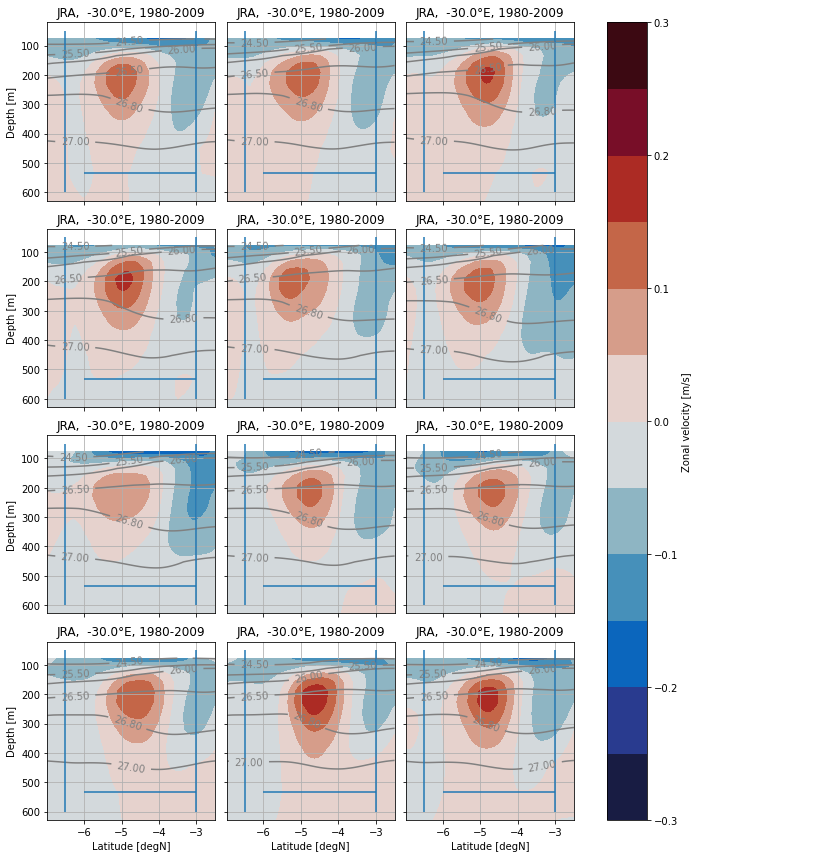

In [32]:
levs = [24.5,25.5,26.0,26.5,26.8,27, 27.5]
lev_u=np.arange(-.3,.31,.05)
ylim= [-6.5,-3]

lon1 = [-40.5, -30.5, -23.5]
lon2 = [-39.5, -29.5, -22.5]
mm_str = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
idx = 0
with xr.set_options(keep_attrs=True):
    uj = ds_JRA_clim.vozocrtx.isel(x_r=idx)
    dj = ds_JRA_clim.sigma_0m.isel(x_c=idx)
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-.3,vmax=.3,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.vlines(ylim,50,600)
    ax.hlines(534.0197,-6,-3)
    ax.set_title('JRA,  %3.1f°E, %s-%s' % (ds_JRA.lon_r[idx],tlim1,tlim2))
    ax.grid()
    ax.annotate(mm_str[i], (3,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_5}_clim{tlim1}_{tlim2}_30W{fig_format}"),dpi=300)

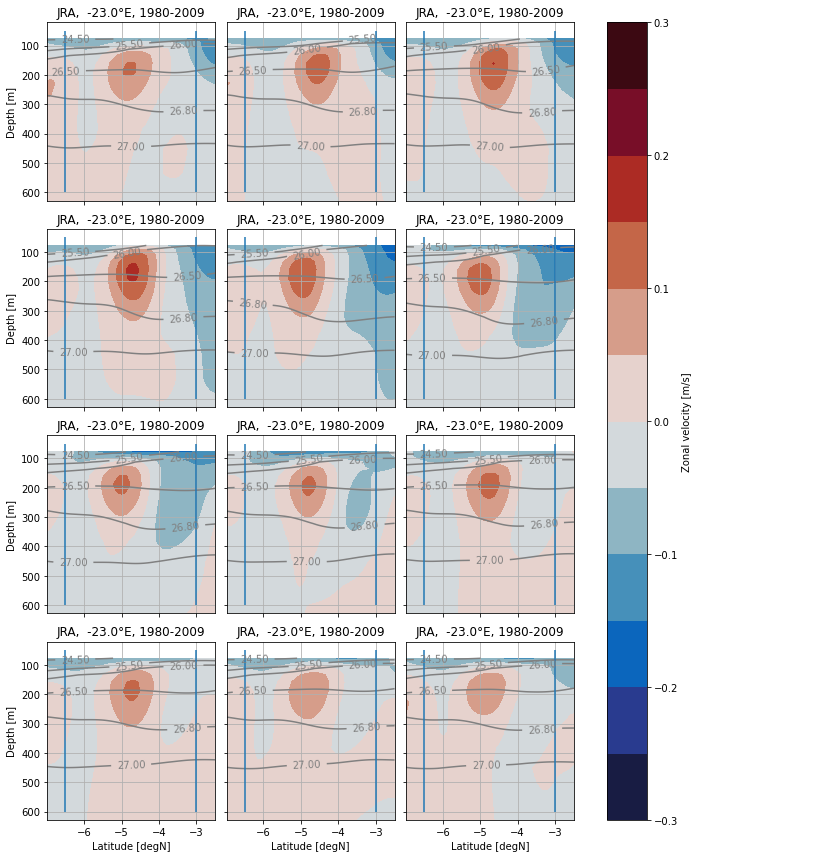

In [33]:
idx = 1
with xr.set_options(keep_attrs=True):
    uj = ds_JRA_clim.vozocrtx.isel(x_r=idx)
    dj = ds_JRA_clim.sigma_0m.isel(x_c=idx)
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-.3,vmax=.3,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    ax.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.set_title('JRA,  %3.1f°E, %s-%s' % (ds_JRA.lon_r[idx],tlim1,tlim2))
    ax.vlines(ylim,50,600)
    ax.grid()
    ax.annotate(mm_str[i], (3,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_5}_clim{tlim1}_{tlim2}_23W{fig_format}"),dpi=300)

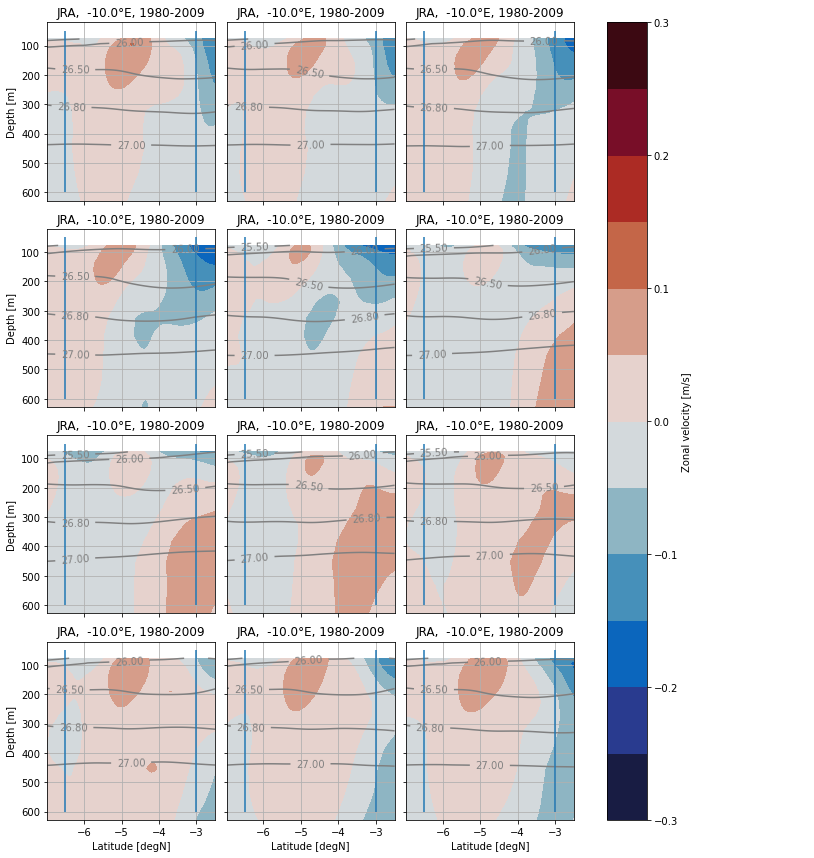

In [34]:
idx = 2
with xr.set_options(keep_attrs=True):
    uj = ds_JRA_clim.vozocrtx.isel(x_r=idx)
    dj = ds_JRA_clim.sigma_0m.isel(x_c=idx)
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-.3,vmax=.3,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.set_title('JRA,  %3.1f°E, %s-%s' % (ds_JRA.lon_r[idx],tlim1,tlim2))
    ax.vlines(ylim,50,600)
    ax.grid()
    ax.annotate(mm_str[i], (3,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_5}_clim{tlim1}_{tlim2}_10W{fig_format}"),dpi=300)

### CORE

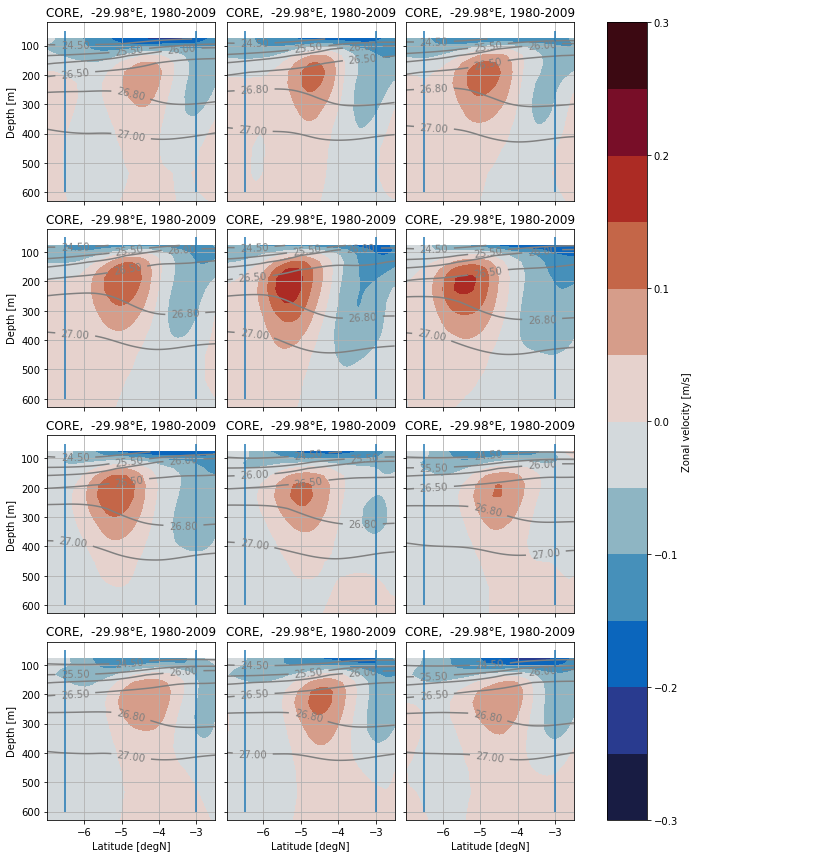

In [35]:
idx = 0
with xr.set_options(keep_attrs=True):
    uj = ds_CORE_clim.vozocrtx.isel(x_r=idx)
    dj = ds_CORE_clim.sigma_0m.isel(x_c=idx)
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-.3,vmax=.3,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.vlines(ylim,50,600)
    ax.set_title('CORE,  %4.2f°E, %s-%s' % (ds_JRA.lon_r[idx],tlim1,tlim2))
    ax.grid()
    ax.annotate(mm_str[i], (3,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_6}_clim{tlim1}_{tlim2}_30W{fig_format}"),dpi=300)

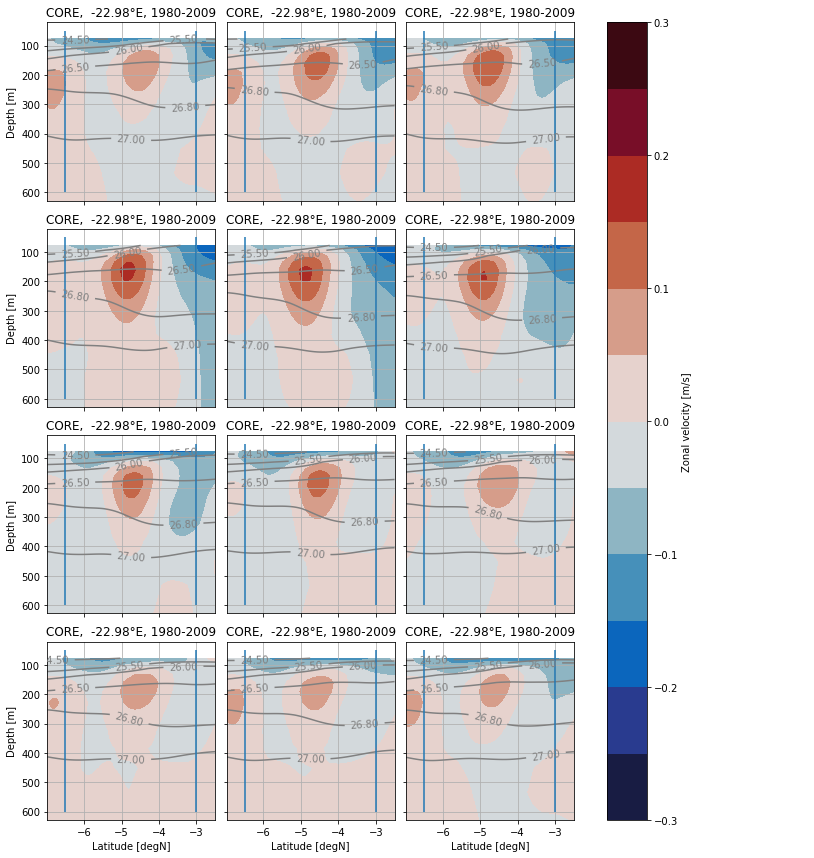

In [36]:
idx = 1
with xr.set_options(keep_attrs=True):
    uj = ds_CORE_clim.vozocrtx.isel(x_r=idx)
    dj = ds_CORE_clim.sigma_0m.isel(x_c=idx)
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-.3,vmax=.3,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.vlines(ylim,50,600)
    ax.set_title('CORE,  %4.2f°E, %s-%s' % (ds_JRA.lon_r[idx],tlim1,tlim2))
    ax.grid()
    ax.annotate(mm_str[i], (3,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')


if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_6}_clim{tlim1}_{tlim2}_23W{fig_format}"),dpi=300)

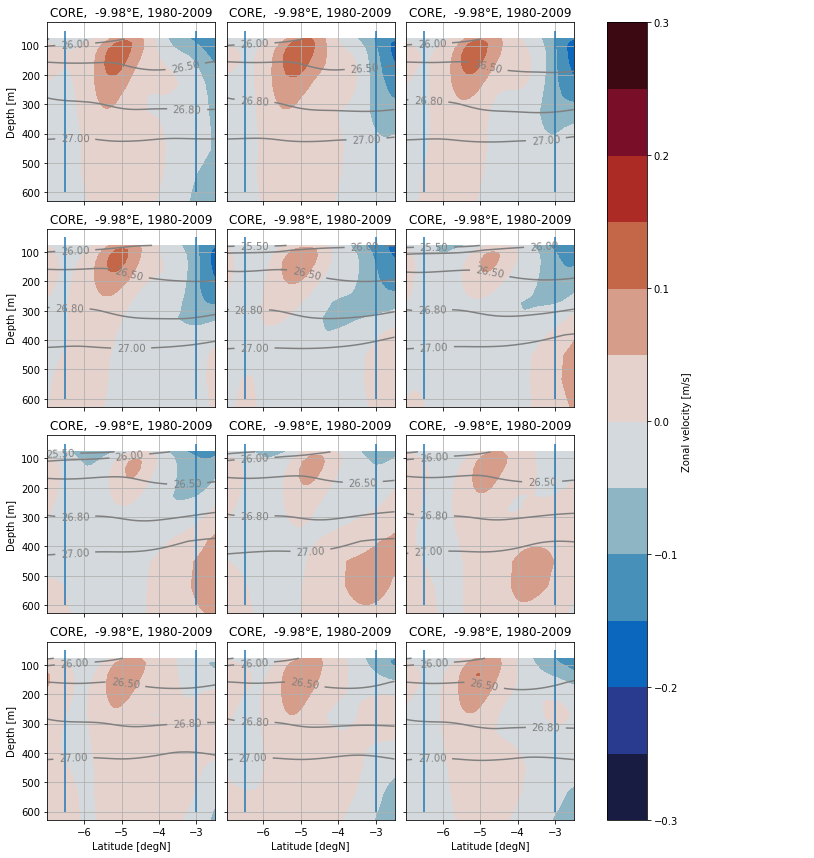

In [37]:
idx = 2
with xr.set_options(keep_attrs=True):
    uj = ds_CORE_clim.vozocrtx.isel(x_r=idx)
    dj = ds_CORE_clim.sigma_0m.isel(x_c=idx)
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-.3,vmax=.3,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.vlines(ylim,50,600)
    ax.set_title('CORE,  %4.2f°E, %s-%s' % (ds_JRA.lon_r[idx],tlim1,tlim2))
    ax.grid()
    ax.annotate(mm_str[i], (3,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')


if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_6}_clim{tlim1}_{tlim2}_10W{fig_format}"),dpi=300)